In [16]:
%matplotlib inline

import elasticsearch
import datetime
import pyes
import json

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


In [17]:
def getBasicInformation(fid, hostIP):

    connection = pyes.es.ES(hostIP)

    termQuery = pyes.query.TermQuery(field = 'fid', value = fid)
    
    querySearch = pyes.query.Search(termQuery)
   
    result = connection.search(query = querySearch,
                               indices = 'facebook_nested',
                               doc_types = 'fanpage')
    
    print('Fan page: ' + str(result[0]['name']))
    
    print('# of fans: ' + str(result[0]['likes_count']))
    
    
    result = connection.search(query = querySearch,
                               indices = 'facebook_nested',
                               doc_types = 'post')
    
    print('# of posts: ' + str(len(result)))
    
    
    result = connection.search(query = querySearch,
                               indices = 'facebook_nested',
                               doc_types = 'like')
    
    print('# of likes: ' + str(len(result)))
    
   
    

In [18]:
#資料統計 三個粉絲頁的基本資訊

fids = ['139624776093433', '1448357445384692', '179080912217031']

hostIP = '127.0.0.1:9200'

for fid in fids:
    getBasicInformation(fid, hostIP)

Fan page: IKEA Taiwan 宜家家居粉絲團
# of fans: 580765
# of posts: 1120


pyes object <pyes.es.ES object at 0x000000000B1A35F8> is being destroyed, but bulk operations have not been flushed. Call force_bulk()!
pyes object <pyes.es.ES object at 0x0000000007882DA0> is being destroyed, but bulk operations have not been flushed. Call force_bulk()!


# of likes: 1400259
Fan page: 台灣大哥大與你生活在一起
# of fans: 60673
# of posts: 969
# of likes: 388321


pyes object <pyes.es.ES object at 0x000000000AD55828> is being destroyed, but bulk operations have not been flushed. Call force_bulk()!


Fan page: 大同TATUNG同樂會
# of fans: 124529
# of posts: 664
# of likes: 304048


In [19]:
def getRationOfPostWithSharing(fid, hostIP):
    
    connection = pyes.es.ES(hostIP)

    termQuery = pyes.query.TermQuery(field = 'fid', value = fid)
    
    querySearch = pyes.query.Search(termQuery)
   
    result = connection.search(query = querySearch,
                               indices = 'facebook_nested',
                               doc_types = 'post')
    
    numOfPost = len(result)
    numOfPostWithSharing = 0
    

    for i in result:
        for j in i:
            if j == 'shares':
                numOfPostWithSharing +=1
                break
    
    print('ratio of post with sharing: ' + str(round(numOfPostWithSharing/numOfPost, 2)))
    print()
    

In [20]:
#資料統計 三個粉絲頁的 ratio of post with sharing

fids = ['139624776093433', '1448357445384692', '179080912217031']

hostIP = '127.0.0.1:9200'

for fid in fids:
     getRationOfPostWithSharing(fid, hostIP)

pyes object <pyes.es.ES object at 0x000000000B139EB8> is being destroyed, but bulk operations have not been flushed. Call force_bulk()!


ratio of post with sharing: 0.98



pyes object <pyes.es.ES object at 0x0000000007AB5FD0> is being destroyed, but bulk operations have not been flushed. Call force_bulk()!


ratio of post with sharing: 0.69



pyes object <pyes.es.ES object at 0x0000000007AB5FD0> is being destroyed, but bulk operations have not been flushed. Call force_bulk()!


ratio of post with sharing: 0.92



In [34]:
def getNumOfLikeFromUniqueUse(fid, hostIP):
    
    conn = pyes.es.ES(hostIP)
    tq = pyes.query.TermQuery(field="fid", value=fid)
    tagg = pyes.aggs.TermsAgg('uid', field= 'uid')
    qsearch = pyes.query.Search(tq) 
    qsearch.agg.add(tagg) 
    result = conn.search(query=qsearch , indices='facebook_nested' , doc_types='like')
    
    #print(json.dumps(result.aggs, indent = 2))
    print(len(result.aggs['uid']['buckets']))

In [ ]:
fids = ['139624776093433', '1448357445384692', '179080912217031']

hostIP = '127.0.0.1:9200'

for fid in fids:
     getNumOfLikeFromUniqueUse(fid, hostIP)

In [23]:
def getNumOfCommentFromUniqueUse(fid, hostIP):
    
    conn = pyes.es.ES(hostIP)
    tq = pyes.query.TermQuery(field="fid", value=fid)
    tagg = pyes.aggs.TermsAgg('uid', field= 'from.id')
    qsearch = pyes.query.Search(tq) 
    qsearch.agg.add(tagg) 
    result = conn.search(query=qsearch , indices='facebook_nested' , doc_types='comment')

    #print(json.dumps(result.aggs, indent = 2))
    print(len(result.aggs['uid']['buckets']))

In [24]:
# fids = ['139624776093433', '1448357445384692', '179080912217031']

# hostIP = '127.0.0.1:9200'

# for fid in fids:
#      getNumOfCommentFromUniqueUse(fid, hostIP)

In [25]:
def boxPlotFBFansPageComp(fids,host,pngFilePath,outlierFilter):
    data=[]
    for fid in fids:
        conn = pyes.es.ES(host)
        tq = pyes.query.TermQuery(field="fid", value=fid)
        tagg = pyes.aggs.TermsAgg('pid', field= 'fid_pid')
        qsearch = pyes.query.Search(tq) 
        qsearch.agg.add(tagg) 
        result = conn.search(query=qsearch , indices='facebook_nested' , doc_types='comment')
        #print json.dumps(result.aggs,indent=2) 
        for fidpid_summary in result.aggs["pid"]["buckets"]:
            #print fidpid_summary["key"] + ',' + str(fidpid_summary["doc_count"])
            if fidpid_summary["doc_count"] < outlierFilter or outlierFilter < 0:
                data.append([fidpid_summary["doc_count"],fid,fidpid_summary["key"]])

    df=pd.DataFrame(data,columns={'count','fid','fidpid'})
    sns.set(style="ticks")
    sns_plot=sns.boxplot(x="fid", y="count", data=df, palette="PRGn")
    fig=sns_plot.get_figure()
    fig.savefig(pngFilePath)

pyes object <pyes.es.ES object at 0x000000000B1A3BE0> is being destroyed, but bulk operations have not been flushed. Call force_bulk()!
pyes object <pyes.es.ES object at 0x000000000B1A3F60> is being destroyed, but bulk operations have not been flushed. Call force_bulk()!
pyes object <pyes.es.ES object at 0x000000000B1A34A8> is being destroyed, but bulk operations have not been flushed. Call force_bulk()!


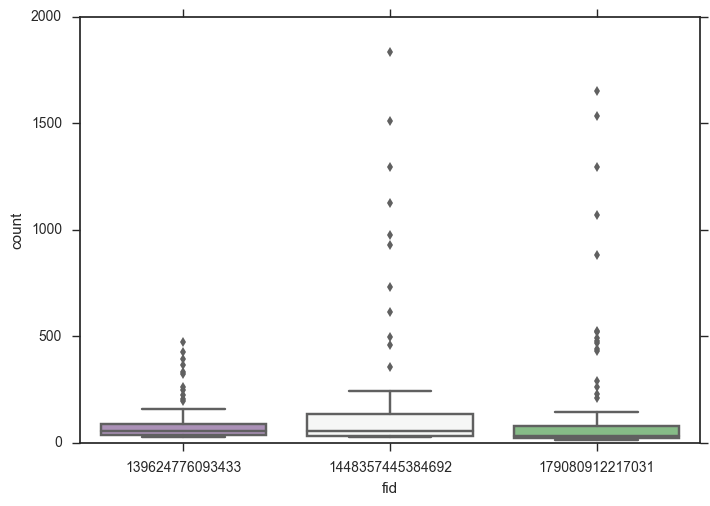

In [26]:
#資料統計 三個粉絲頁每篇Post下的Comments分佈情況

fids=['139624776093433','1448357445384692','179080912217031']

host = '127.0.0.1:9200'

pngFilePath="output.png"

outlierFilter=2000

boxPlotFBFansPageComp(fids,host,pngFilePath,outlierFilter)

In [27]:
import pyes
import json
import pandas as pd
import seaborn as sns
import datetime
import matplotlib.pyplot as plt


def boxPlotNumofPostPerMonth(fid,host,lowerbound,upperbound,pngFilePath):
    conn = pyes.es.ES(host)
    tq = pyes.query.TermQuery(field="fid", value=fid)
    #tagg = pyes.aggs.TermsAgg('pid', field= 'fid_pid')
    DHAgg = pyes.aggs.DateHistogramAgg('month' ,field='created_time', interval='month',sub_aggs=[])
    tagg = pyes.aggs.TermsAgg('pid', field= 'fid_pid')
    DHAgg.sub_aggs.append(tagg) 
    qsearch = pyes.query.Search(tq) 
    qsearch.agg.add(DHAgg) 
    result = conn.search(query=qsearch , indices='facebook_nested' , doc_types='comment')

    data=[]
    for r in result.aggs["month"]["buckets"]:
        for pid in r["pid"]["buckets"]:
            monthyear=datetime.datetime.strptime(r["key_as_string"], "%Y-%m-%dT%H:%M:%S.%fZ").strftime('%Y/%m')
            data.append([pid["doc_count"],monthyear,pid["key"],r["key"]])

    df=pd.DataFrame(data,columns={'date','count','fid','pid'})
    sns.set(style="ticks")
    sns_plot=sns.boxplot(x = "date", y = "count", data = df, palette = "PRGn")
    fig=sns_plot.get_figure()
    plt.ylim(lower_bound, upper_bound)
    fig.savefig(pngFilePath)

pyes object <pyes.es.ES object at 0x000000000BF4FA20> is being destroyed, but bulk operations have not been flushed. Call force_bulk()!


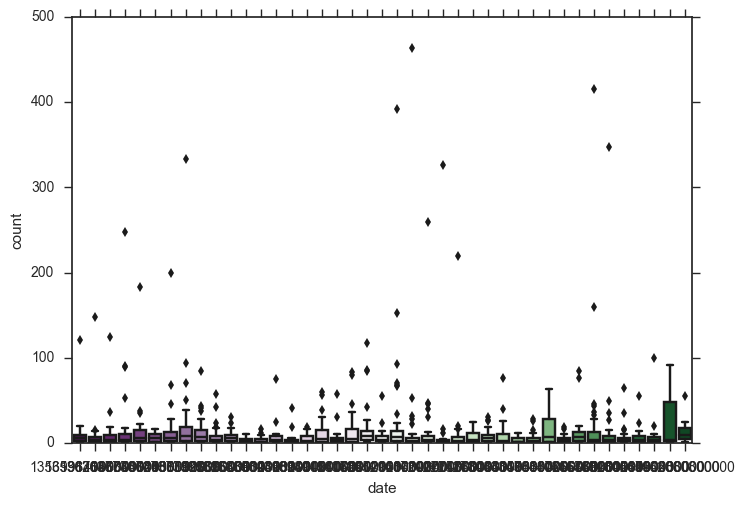

In [28]:
#IKEA粉絲頁數個月間每個月Post下的Comments分佈情況

host = '127.0.0.1:9200'
lower_bound = 0
upper_bound = 500
fid="139624776093433"
pngFilePath="output3.png"
boxPlotNumofPostPerMonth(fid,host,lower_bound,upper_bound,pngFilePath)

pyes object <pyes.es.ES object at 0x000000000BF4C4A8> is being destroyed, but bulk operations have not been flushed. Call force_bulk()!


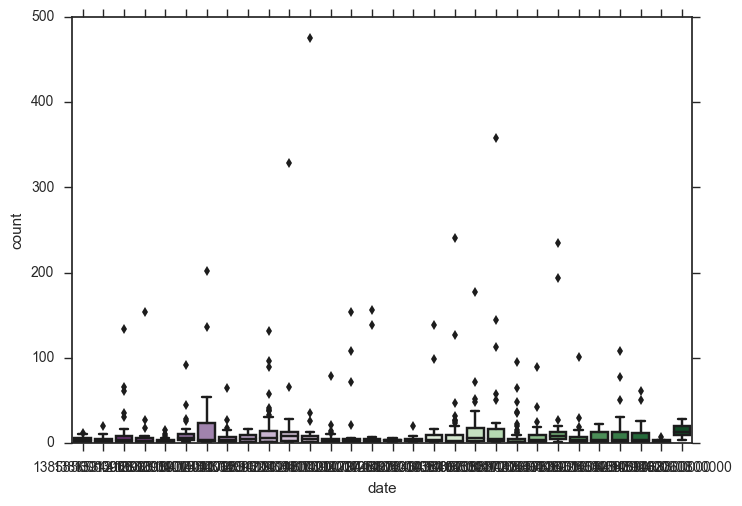

In [29]:
#台哥大粉絲頁數個月間每個月Post下的Comments分佈情況

host = '127.0.0.1:9200'
lower_bound = 0
upper_bound = 500
fid="1448357445384692"
pngFilePath="output4.png"
boxPlotNumofPostPerMonth(fid,host,lower_bound,upper_bound,pngFilePath)

pyes object <pyes.es.ES object at 0x000000000B1A3630> is being destroyed, but bulk operations have not been flushed. Call force_bulk()!


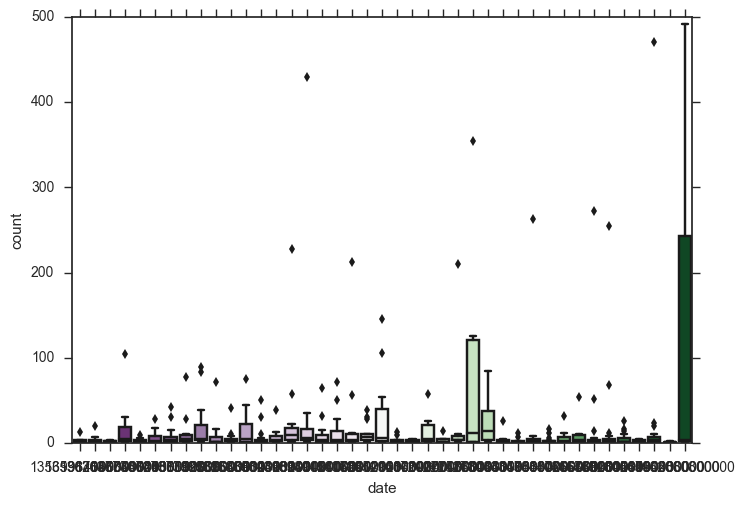

In [30]:
#大同粉絲頁數個月間每個月Post下的Comments分佈情況

host = '127.0.0.1:9200'
lower_bound = 0
upper_bound = 500
fid="179080912217031"
pngFilePath="output5.png"
boxPlotNumofPostPerMonth(fid,host,lower_bound,upper_bound,pngFilePath)

In [31]:
import pyes
import json

def getUserPostFreqMatrix(host,row,column,fid):
    
    rc=200
    cc=200
    
    rowIndexList,colIndexList,matrix = [],[],[]
    conn=pyes.es.ES(host)
    tq = pyes.query.TermQuery(field="fid", value=fid)

    tagg = pyes.aggs.TermsAgg('from.id', field = 'from.id', sub_aggs=[]) 
    tagg1 = pyes.aggs.TermsAgg('fid_pid', field = 'fid_pid')  
    tagg.sub_aggs.append(tagg1) 

    qsearch = pyes.query.Search(tq) 
    qsearch.agg.add(tagg)

    rs = conn.search(query=qsearch, indices='facebook_nested', doc_types='comment')
    
    rowcount=0
    colcount=0
    
    for user in rs.aggs[row]['buckets']:
        if user['key']!="" and user['key'] not in rowIndexList and rowcount<rc:
            rowIndexList.append(user['key'])
            rowcount=rowcount+1

        for post in user[column]['buckets']:
            if post['key'] not in colIndexList and colcount<cc:
                colIndexList.append(post['key'])
                colcount=colcount+1

    for i in range(0,len(rowIndexList)):
        matrix.append([0.0]*len(colIndexList))

    for user in rs.aggs[row]['buckets']:
        if user["key"] in rowIndexList:
            for post in user[column]['buckets']:
                if post['key'] in colIndexList:
                    matrix[rowIndexList.index(user['key'])][colIndexList.index(post['key'])] = float(post['doc_count'])
    
    
    return {"data":matrix,"col":colIndexList,"row":rowIndexList}

In [32]:
host = '127.0.0.1:9200'
row="from.id"
column="fid_pid"


fid="179080912217031"
result = getUserPostFreqMatrix(host,row,column,fid)

pyes object <pyes.es.ES object at 0x000000000C38D208> is being destroyed, but bulk operations have not been flushed. Call force_bulk()!


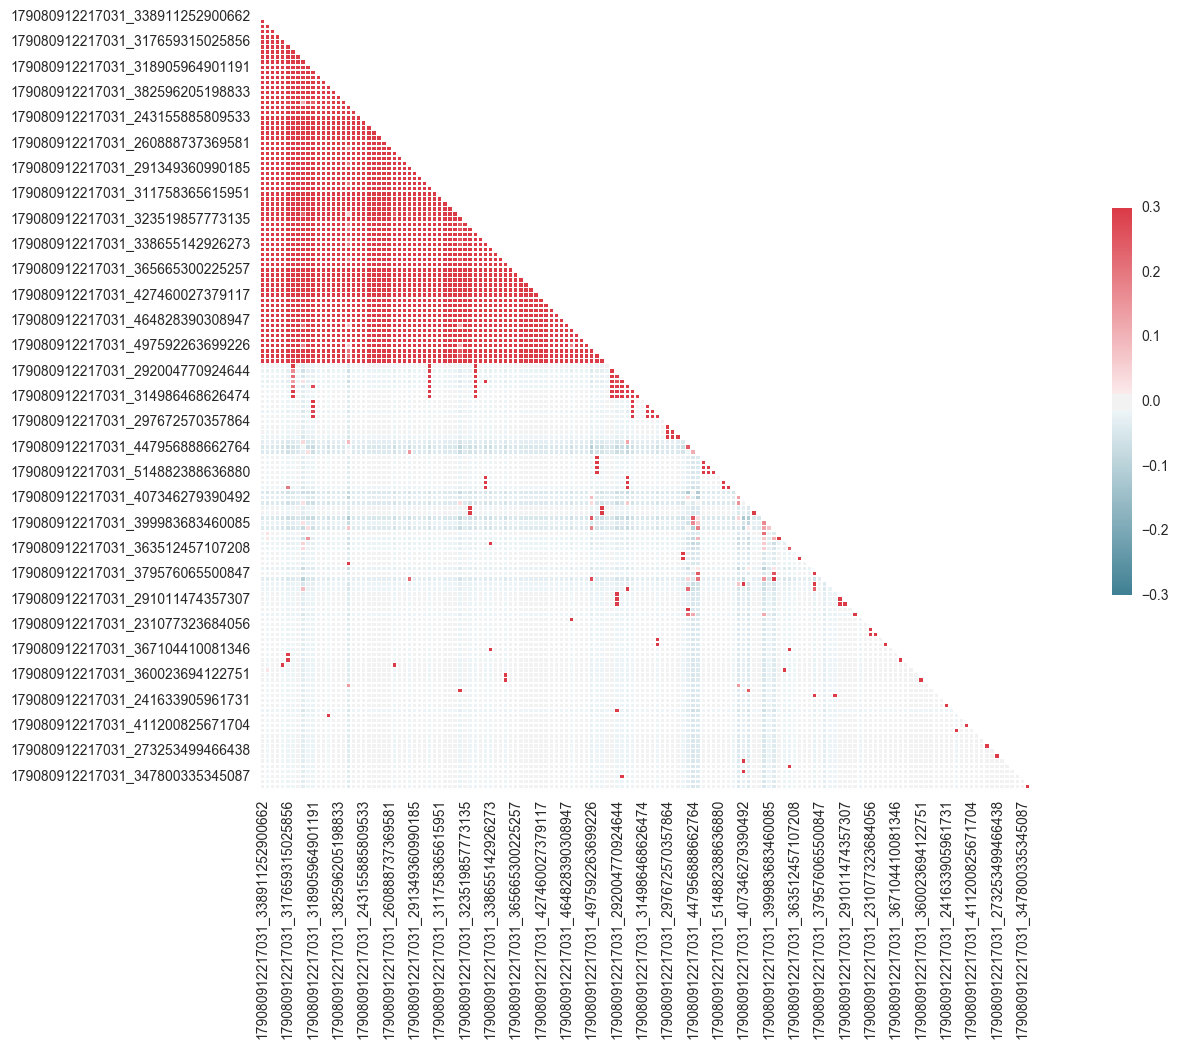

In [33]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Generate a large random dataset
d = pd.DataFrame(data=result["data"],
                 columns=result["col"])

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)